# Previsão de Potencial de Falha de Maquinário

O objetivo do presente projeto é identificar quais máquinas apresentam potencial de falha, tendo como base dados extraídos de sensores durante o processo de manufatura.

## 0. Importação de Bibliotecas e *Helper Functions*

In [216]:
import warnings
import numpy   as np
import pandas  as pd
import seaborn as sns
from boruta                  import BorutaPy
from matplotlib              import pyplot as plt
from sklearn.metrics         import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

In [3]:
def personal_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['font.size'] = 20
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x:'%.2f' % x)
    sns.set()
    sns.set(rc = {'figure.figsize':(12,6)})
    warnings.filterwarnings('ignore')

personal_settings()

In [217]:
def model_avaliation(data, y_hat, y_val, model_name):
    '''Função para preparar os dados, calcular o precision e recall @ k e retornar os valors em um dataframe'''
    df = data.copy()
    df['classification'] = y_hat.tolist()
    
    precision = precision_score(y_val, y_hat, average='macro')
    recall = recall_score(y_val, y_hat, average='macro')
    accuracy = accuracy_score(y_val, y_hat)
    
    return pd.DataFrame({'Precision': precision,
                        'Recall': recall,
                        'Accuracy': accuracy}, index=[model_name])

def cross_validation(model_name, model, x_train, y_train, verbose=False):
    '''Função para realizar o Cross Validation dos modelos de Machine Learning'''
    precision_list = []
    recall_list    = []
    
    kfolds = StratifiedKFold(n_splits = 5, shuffle=True, random_state=5)
    
    for cv_train, cv_val in kfolds.split(x_train, y_train):
        
        # Cross-Validation Train
        xtrain_val = x_train.iloc[cv_train]
        ytrain_val = y_train.iloc[cv_train]
        
        # Cross-Validation Validation
        xval = x_train.iloc[cv_val]
        yval = y_train.iloc[cv_val]
        
        # Treinamento do modelo
        model.fit(xtrain_val, ytrain_val)

        # Previsão
        yhat = model.predict(xval)
        
        # Preparando os Dados
        data = xval.copy()
        data['failure_type'] = yval.copy()

        # Score
        data['classification'] = yhat.tolist()

        # Performance
        precision = precision_score(yval, yhat, average='macro')
        precision_list.append(precision)
        
        recall = recall_score(yval, yhat, average='macro')
        recall_list.append(recall)
        
        acc = accuracy_score(yval, yhat)
        
    return pd.DataFrame({'Precision - CV': np.round(np.mean(precision_list), 3),
                         'Recall - CV': np.round(np.mean(recall_list), 3),
                         'Accuracy - CV': np.round(np.mean(acc), 3)},index=[model_name])

## 1. Carregando os Dados

Simples importação e exibição dos 05 primeiros registros do conjunto de dados, para ter um contato inicial com os dados.

In [4]:
df_raw = pd.read_csv('../data/desafio_manutencao_preditiva_treino.csv')
df_raw.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.10,308.60,1551,42.80,0,No Failure
1,2,L47181,L,298.20,308.70,1408,46.30,3,No Failure
2,5,L47184,L,298.20,308.70,1408,40.00,9,No Failure
3,6,M14865,M,298.10,308.60,1425,41.90,11,No Failure
4,7,L47186,L,298.10,308.60,1558,42.40,14,No Failure


## 2. Descrição dos Dados

In [5]:
df1 = df_raw.copy()

### 2.1 Dicionário de Colunas

In [7]:
df1.columns

Index(['udi', 'product_id', 'type', 'air_temperature_k',
       'process_temperature_k', 'rotational_speed_rpm', 'torque_nm',
       'tool_wear_min', 'failure_type'],
      dtype='object')

Criar esse dicionário de colunas vai facilitar para entender o que os valores de cada atributo representam.

|    Atributos         |                         Significado                          |
| :------------------: | :----------------------------------------------------------: |
|udi                   |identificador único|
|product_id            |identificador único do produto|
|type                  |tipo do produto de acordo com sua qualidade (L para *low*, M para *medium* e H para *high*)|
|air_temperature_k     |temperatura do ar em Kelvins|
|process_temperature_k |temperatura do processo em Kelvins|
|rotational_speed_rpm  |velocidade rotacional em Rotações por Minuto|
|torque_nm             |medição do torque em Newton metro|
|tool_wear_min         |desgaste da ferramenta utilizada no processo em minutos|
|failure_type (variável resposta) |indica se a máquina falhou ou não (*No Failure*, *Power Failure*, *Tool Wear Failure*, *Overstrain Failure*, *Random Failures*, *Heat Dissipation Failure*) |

### 2.2 Dimensões

In [14]:
print(f'Número de registros/linhas:   {df1.shape[0]}')
print(f'Número de atributos/colunas: {df1.shape[1]}')

Número de registros/linhas:   6667
Número de atributos/colunas: 9


### 2.3 Tipos de Dados

In [15]:
df1.dtypes

udi                        int64
product_id                object
type                      object
air_temperature_k        float64
process_temperature_k    float64
rotational_speed_rpm       int64
torque_nm                float64
tool_wear_min              int64
failure_type              object
dtype: object

Olhando para os tipos de dados de cada atributo, bem como para o conjunto de dados em si, não vejo necessidade de alterar algum tipo de dado.

### 2.4 Valores Nulos

In [17]:
df1.isna().sum()

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64

Não temos nenhum valor nulo no conjunto de dados, então não preciso me preocupar em remover ou preencher valores faltantes.

### 2.5 Registros Duplicados

In [29]:
df1.duplicated().sum()

0

Também não temos nenhum registro duplicado.

### 2.6 Análise Estatística Descritiva

#### 2.6.1 Atributos Numéricos

In [18]:
df1_numerical = df1.select_dtypes(include= ['int64', 'float64'])
df1_numerical.head()

,udi,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,1,298.10,308.60,1551,42.80,0
1,2,298.20,308.70,1408,46.30,3
2,5,298.20,308.70,1408,40.00,9
3,6,298.10,308.60,1425,41.90,11
4,7,298.10,308.60,1558,42.40,14


Verificando o dicionário de colunas, vou remover a coluna *udi*, já que somente corresponde a um identificador único da medição do sensor.

In [19]:
df1_numerical = df1_numerical.drop('udi', axis=1)
df1_numerical.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,298.10,308.60,1551,42.80,0
1,298.20,308.70,1408,46.30,3
2,298.20,308.70,1408,40.00,9
3,298.10,308.60,1425,41.90,11
4,298.10,308.60,1558,42.40,14


Agora vou calcular algumas medidas de estatística para ter uma noção da concentração e distribuição de valores para cada um desses atributos.

In [22]:
df_mean     = pd.DataFrame(df1_numerical.apply(np.mean)).T
df_median   = pd.DataFrame(df1_numerical.apply(np.median)).T
df_std      = pd.DataFrame(df1_numerical.apply(np.std)).T
df_min      = pd.DataFrame(df1_numerical.apply(min)).T
df_max      = pd.DataFrame(df1_numerical.apply(max)).T
df_range    = pd.DataFrame(df1_numerical.apply(lambda x: x.max() - x.min())).T
df_skew     = pd.DataFrame(df1_numerical.apply(lambda x: x.skew())).T
df_kurtosis = pd.DataFrame(df1_numerical.apply(lambda x: x.kurtosis())).T

In [23]:
df_desc = pd.concat([df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis]).T.reset_index()
df_desc.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
df_desc

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,air_temperature_k,295.30,304.50,9.20,299.99,300.00,1.99,0.13,-0.82
1,process_temperature_k,305.70,313.80,8.10,309.99,310.00,1.49,0.02,-0.51
2,rotational_speed_rpm,1168.00,2886.00,1718.00,1537.42,1503.00,177.17,1.95,7.31
3,torque_nm,3.80,76.60,72.80,40.06,40.20,9.95,0.01,0.01
4,tool_wear_min,0.00,251.00,251.00,108.10,108.00,63.36,0.02,-1.16


Interpretando a tabela: 
- min: 
- max: 
- range: 
- mean: 
- median:
- std: 
- skew: 
- kurtosis: 

#### 2.6.2 Atributos Categóricos

In [41]:
df1_categorical = df1.select_dtypes(exclude=['int64', 'float64'])
df1_categorical.head()

,product_id,type,failure_type
0,M14860,M,No Failure
1,L47181,L,No Failure
2,L47184,L,No Failure
3,M14865,M,No Failure
4,L47186,L,No Failure


In [46]:
df1_categorical['product_id'].shape[0]

6667

In [39]:
df1_categorical['type'].value_counts()

L    4022
M    1987
H     658
Name: type, dtype: int64

In [40]:
df1_categorical['failure_type'].value_counts()

No Failure                  6435
Heat Dissipation Failure      75
Power Failure                 63
Overstrain Failure            52
Tool Wear Failure             30
Random Failures               12
Name: failure_type, dtype: int64

## 3. Análise Exploratória dos Dados

In [47]:
df2 = df1.copy()

### 3.1 Análise Univariada

#### 3.1.1 Variável Resposta

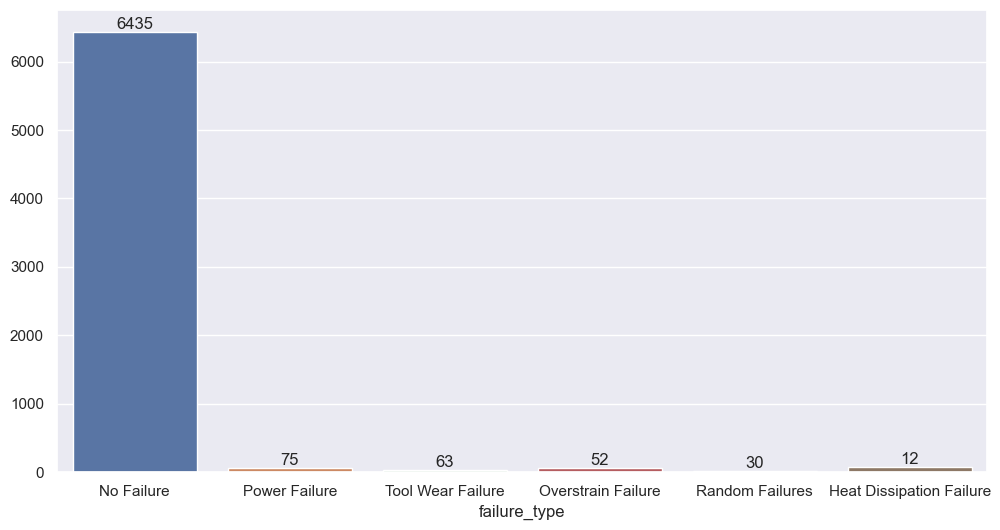

In [53]:
a = sns.countplot(x='failure_type', data=df2)
values = df2['failure_type'].value_counts().values
a.bar_label(container=a.containers[0], labels=values)
a.set(ylabel=None);

#### 3.1.2 Variáveis Numéricas

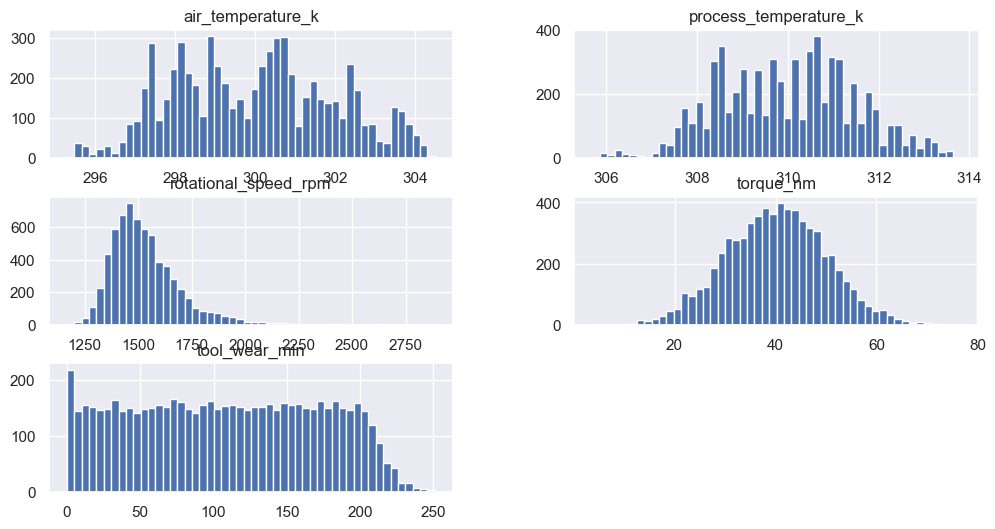

In [58]:
df1_numerical.hist(bins=50);

#### 3.1.3 Variáveis Categóricas

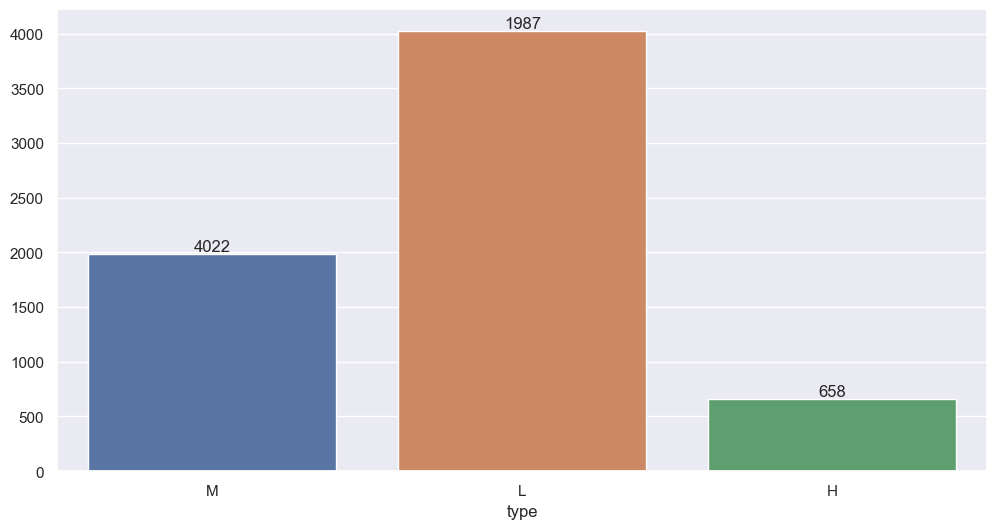

In [64]:
a = sns.countplot(x='type', data=df2)
values = df2['type'].value_counts().values
a.bar_label(container=a.containers[0], labels=values)
a.set(ylabel=None);

### 3.2 Análise Bivariada - Validação de Hipóteses

### 3.3 Análise Multivariada

#### 3.3.1 Variáveis Numéricas

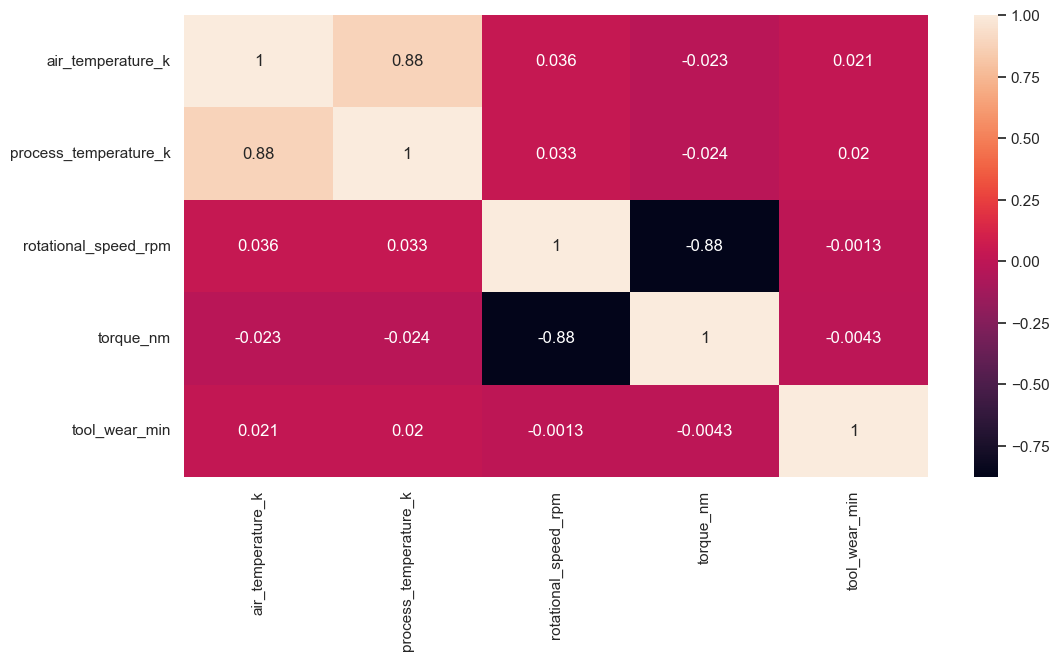

In [65]:
correlation = df1_numerical.corr(method='pearson')
sns.heatmap(correlation, annot=True);

## 4. Preparação dos Dados

In [136]:
df3 = df2.copy()

### 4.1 Separando o Conjunto de Dados

Primeiro de tudo, vou separar o conjunto de dados entre Treino e Validação.

In [137]:
x = df3.drop('failure_type', axis=1)
y = df3['failure_type'].copy()

In [138]:
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.20)

In [139]:
df_train = pd.concat([x_train, y_train], axis=1)
df_train.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
1920,2846,L50025,L,300.30,309.20,1398,54.40,198,No Failure
5585,8386,H37799,H,298.80,309.80,1563,38.80,65,No Failure
1256,1886,L49065,L,298.00,307.60,1683,32.80,122,No Failure
6363,9549,L56728,L,299.60,311.10,1521,37.20,131,No Failure
1989,2946,H32359,H,300.70,309.60,1925,20.50,9,No Failure


In [140]:
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(5333, 8) (5333,)
(1334, 8) (1334,)


### 4.2 Normalização

#### 4.2.1 *torque_nm*

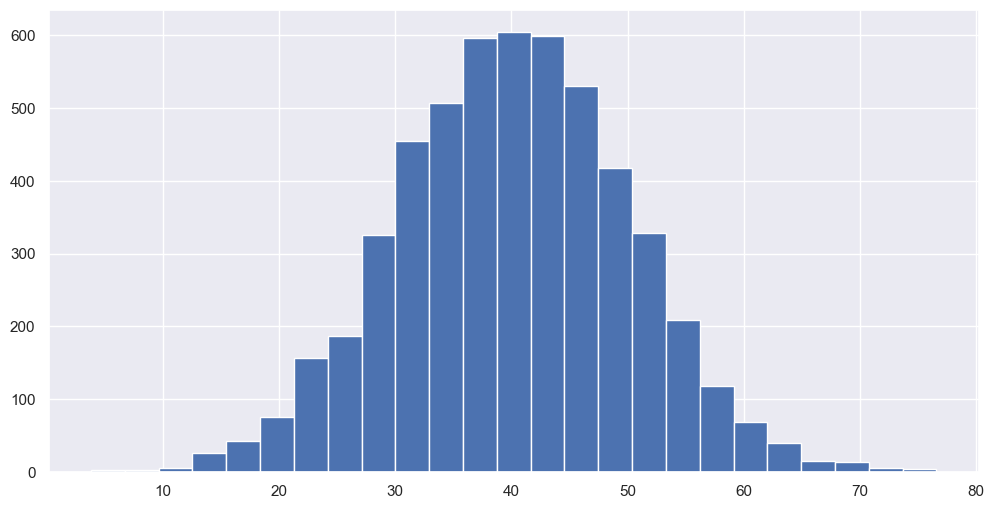

In [141]:
df_train['torque_nm'].hist(bins=25);

In [142]:
ss_torque = StandardScaler()
df_train['torque_nm'] = ss_torque.fit_transform(df_train[['torque_nm']].values)
df_train['torque_nm'].head()

1920    1.44
5585   -0.13
1256   -0.73
6363   -0.29
1989   -1.97
Name: torque_nm, dtype: float64

### 4.3 *Rescaling*

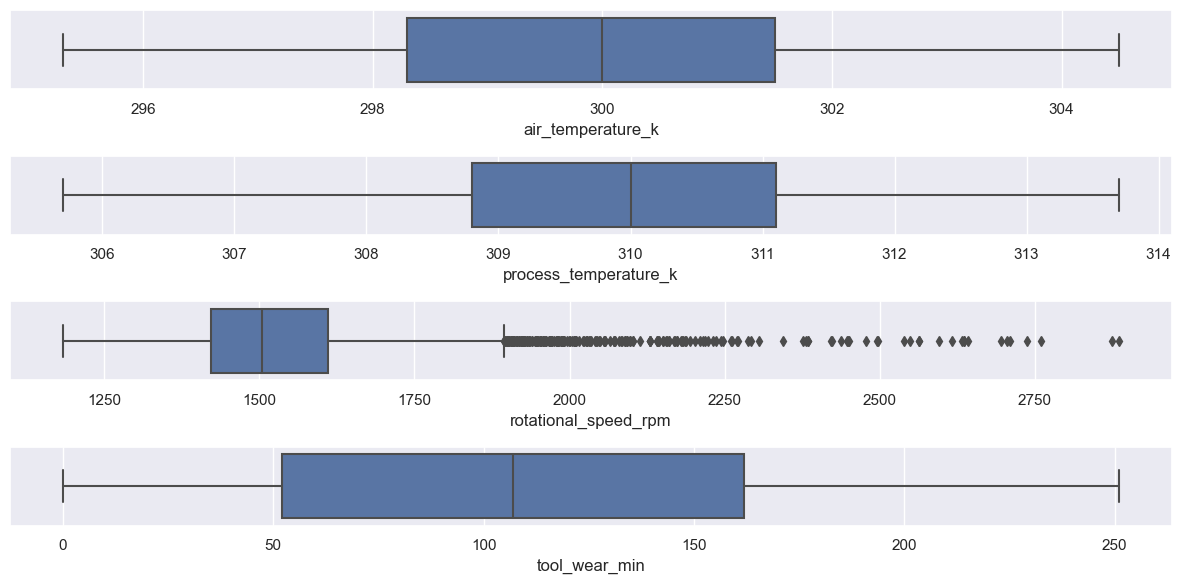

In [143]:
plt.subplot(4, 1, 1)
sns.boxplot(data=df_train, x='air_temperature_k')

plt.subplot(4, 1, 2)
sns.boxplot(data=df_train, x='process_temperature_k')

plt.subplot(4, 1, 3)
sns.boxplot(data=df_train, x='rotational_speed_rpm')

plt.subplot(4, 1, 4)
sns.boxplot(data=df_train, x='tool_wear_min')

plt.tight_layout();

#### 4.3.1 *air_temperature_k*

In [144]:
mms_air_temperature = MinMaxScaler()
df_train['air_temperature_k'] = mms_air_temperature.fit_transform(df_train[['air_temperature_k']].values)

#### 4.3.2 *process_temperature_k*

In [145]:
mms_process_temperature = MinMaxScaler()
df_train['process_temperature_k'] = mms_process_temperature.fit_transform(df_train[['process_temperature_k']].values)

#### 4.3.3 *rotational_speed_rpm*

In [146]:
rs_rotational_speed = RobustScaler()
df_train['rotational_speed_rpm'] = rs_rotational_speed.fit_transform(df_train[['rotational_speed_rpm']].values)

#### 4.3.4 *tool_wear_min*

In [147]:
mms_tool_wear = MinMaxScaler()
df_train['tool_wear_min'] = mms_tool_wear.fit_transform(df_train[['tool_wear_min']].values)

#### 4.3.5 Verificando o *rescaling*

In [148]:
df_train[['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'tool_wear_min']].head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,tool_wear_min
1920,0.54,0.44,-0.56,0.79
5585,0.38,0.51,0.31,0.26
1256,0.29,0.24,0.95,0.49
6363,0.47,0.68,0.09,0.52
1989,0.59,0.49,2.23,0.04


### 4.4 Transformação

#### 4.4.1 *Encoding* - Transformação de Variáveis Categóricas em Numéricas

##### *type*

Ordinal Encoding

In [149]:
type_dict = {'L': 0, 'M': 1, 'H': 2}
df_train['type'] = df_train['type'].map(type_dict)
df_train['type'].unique()

array([0, 2, 1], dtype=int64)

##### *failure_type*

In [150]:
df_train['failure_type'].unique()

array(['No Failure', 'Power Failure', 'Heat Dissipation Failure',
       'Random Failures', 'Tool Wear Failure', 'Overstrain Failure'],
      dtype=object)

In [133]:
#failure_dict = {'No Failure': 0, 'Heat Dissipation Failure': 1, 'Random Failures': 2, 'Power Failure': 3, 'Tool Wear Failure': 4, 'Overstrain Failure': 5}
#df_train['failure_type'] = df_train['failure_type'].map(failure_dict)
#df_train['failure_type'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

### 4.5 Preparação dos Dados - Conjunto de Validação

Aqui vou preparar os dados de Validação com base na preparação e transformações feitas em cima dos dados de Treino.

In [151]:
x_validation.loc[:, 'type'] = x_validation.loc[:, 'type'].map(type_dict)
x_validation.loc[:, 'air_temperature_k'] = mms_air_temperature.transform(x_validation[['air_temperature_k']].values)
x_validation.loc[:, 'process_temperature_k'] = mms_process_temperature.transform(x_validation[['process_temperature_k']].values)
x_validation.loc[:, 'rotational_speed_rpm'] = rs_rotational_speed.transform(x_validation[['rotational_speed_rpm']].values)
x_validation.loc[:, 'torque_nm'] = ss_torque.transform(x_validation[['torque_nm']].values)
x_validation.loc[:, 'tool_wear_min'] = mms_tool_wear.transform(x_validation[['tool_wear_min']].values)

In [152]:
x_validation.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
781,1165,L48344,0,0.20,0.30,1.32,-0.98,0.82
4577,6873,L54052,0,0.62,0.70,-0.17,-0.48,0.29
2982,4450,M19309,1,0.77,0.58,-0.67,1.43,0.66
3287,4917,H34330,2,0.88,0.83,1.40,-1.23,0.16
10,17,M14876,1,0.36,0.44,-1.02,0.66,0.18


## 5 Seleção de Variáveis - *Feature Selection*

In [166]:
df4 = df_train.copy()

### 5.1 Seleção das Variáveis Usando o Boruta

In [163]:
x_train_n = df4.drop(['udi', 'product_id', 'failure_type'], axis=1).values
y_train_n = y_train.values.ravel()

In [164]:
rf = RandomForestRegressor(n_jobs=-1)

In [ ]:
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2).fit(x_train_n, y_train_n)

### 5.2 Seleção das Variáveis Usando *ExtraTreesClassifier*

In [162]:
forest = ExtraTreesClassifier(n_estimators = 250, random_state = 0, n_jobs=-1)

In [167]:
x_train_n = df4.drop(['udi', 'product_id', 'failure_type'], axis=1)
y_train_n = y_train.values

In [168]:
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [169]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
index = np.argsort(importances)[::-1]

df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis = 0)

display(df.sort_values('importance', ascending=False))

,feature,importance
0,torque_nm,0.30
0,rotational_speed_rpm,0.21
0,tool_wear_min,0.17
0,air_temperature_k,0.15
0,process_temperature_k,0.13
0,type,0.03


ESCOLHA: tirar a variável type, por sua pouca importância, ou deixar, em razão do pouco número de variáveis do conjunto de dados;

### 5.3 Variáveis Selecionadas

In [171]:
cols_selected = ['type', 'air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 
                 'torque_nm', 'tool_wear_min']

## 6. Modelos de Machine Learning

In [172]:
df5 = df4.copy()

### 6.1 Preparando os Dados

In [173]:
x_train = df5[cols_selected]
x_train.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
1920,0,0.54,0.44,-0.56,1.44,0.79
5585,2,0.38,0.51,0.31,-0.13,0.26
1256,0,0.29,0.24,0.95,-0.73,0.49
6363,0,0.47,0.68,0.09,-0.29,0.52
1989,2,0.59,0.49,2.23,-1.97,0.04


In [174]:
x_val = x_validation[cols_selected]
x_val.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
781,0,0.20,0.30,1.32,-0.98,0.82
4577,0,0.62,0.70,-0.17,-0.48,0.29
2982,1,0.77,0.58,-0.67,1.43,0.66
3287,2,0.88,0.83,1.40,-1.23,0.16
10,1,0.36,0.44,-1.02,0.66,0.18


In [175]:
y_val = y_validation.copy()
y_val.head()

781                   No Failure
4577                  No Failure
2982    Heat Dissipation Failure
3287                  No Failure
10                    No Failure
Name: failure_type, dtype: object

### 6.2 KNN

In [177]:
knn_model = KNeighborsClassifier(n_neighbors = 7)

In [178]:
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [179]:
yhat_knn = knn_model.predict(x_val)

## 7. Performance dos Modelos

In [202]:
df6 = x_validation.copy()
df6['failure_type'] = y_validation.copy()
df6.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
781,1165,L48344,0,0.20,0.30,1.32,-0.98,0.82,No Failure
4577,6873,L54052,0,0.62,0.70,-0.17,-0.48,0.29,No Failure
2982,4450,M19309,1,0.77,0.58,-0.67,1.43,0.66,Heat Dissipation Failure
3287,4917,H34330,2,0.88,0.83,1.40,-1.23,0.16,No Failure
10,17,M14876,1,0.36,0.44,-1.02,0.66,0.18,No Failure


### 7.1 Performance sem Cross-Validation

In [213]:
knn_aval = model_avaliation(df6, yhat_knn, y_val, 'KNN')
knn_aval

,Precision,Recall,Accuracy
KNN,0.60,0.42,0.98


### 7.2 Performance com Cross-Validation

In [218]:
knn_cv = cross_validation('KNN', knn_model, x_train, y_train)
knn_cv

,Precision - CV,Recall - CV,Accuracy - CV
KNN,0.48,0.28,0.97


## 8. *Hyperparemeter Fine Tunning*

### 8.1 *Random Search*

### 8.2 Desempenho do Modelo Final